In [4]:
import pandas as pd
import gzip
import re
import matplotlib.pyplot as plt
import numpy as np
import os

# Donor1 - YFL

Found 3407 high-confidence variants
Removed 45/3407 variants that are germline or located in poor alignment region, 3362 variants passed
Write stats of HCVs...
Removed 792 cells with low coverage (<10x), 6637 cells remained.
Identified 43 germline mutations from bulk and 1 new germline mutations from the vaf matrix.


/tmp/ipykernel_5621/3436014665.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_vaf_df[final_vaf_df<0.05] = 0
/data/wangxin/software/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


Write the final VAF table.
Write final sorted VAF table
Job finished: YFL.


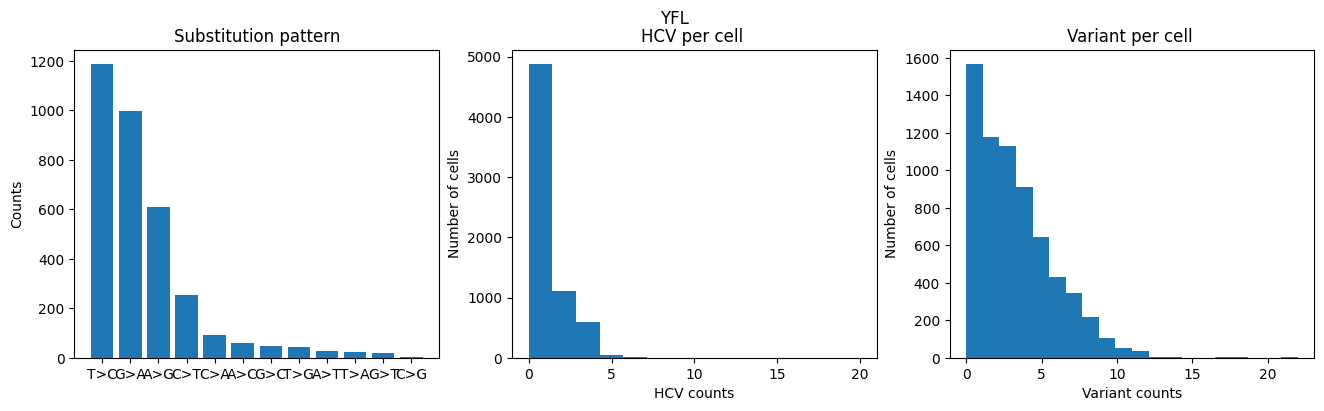

In [40]:
germline_pool = []

sample_name = "YFL"
main_dir = "/data3/wangxin/PBMC/" + sample_name + "/"
snv_dir = main_dir + "SNV/"
counts_dir = main_dir + "counts/"
bulk_snv = main_dir + sample_name + "_all.snv"
depth_file = main_dir + sample_name + "_mean_depth.csv"
snv_ls = os.listdir(snv_dir)
output_dir=main_dir + "outs/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

#germline variants cutoff setup
germline_vaf_co = 0.05
germline_cell_co = 0.9


#identify high confidence variants in each cell and make a dictionary for storage.
hc_var_dict = {}
for i in snv_ls:
    snv_file = open(snv_dir+i,"r")
    hc_var = []
    for j in snv_file.readlines():
        if "Chrom" not in j:
            line = j.strip().split("\t")
            depth = int(line[4]) + int(line[5])
            var_counts = int(line[5])
            strand_balance = int(line[16]) / var_counts
            vaf = var_counts / depth
            if depth >= 20 and var_counts >= 4 and strand_balance >= 0.3 and strand_balance <= 0.7 and vaf >= 0.05:
                hc_var.append((line[1] + line[2] + ">" + line[-1]))
    hc_var_dict[i[:-4]] = hc_var
                
#Count unique variants that are idetified.
all_var=[]
for i in hc_var_dict:
    all_var = all_var + hc_var_dict[i]

hc_var_stat = pd.Series(all_var).value_counts() 
print("Found %d high-confidence variants" %(len(hc_var_stat)))

#remove variants that fall in blacklist or poor alignment region.
bulk_var_pd = pd.read_table(bulk_snv)
germline_var_pd = bulk_var_pd.loc[pd.Series([float(i[:-1])/100 for i in bulk_var_pd["VarFreq"]])>0.9]
germline_var = [str(germline_var_pd.loc[i, "Position"])+germline_var_pd.loc[i, "Ref"]+">"+germline_var_pd.loc[i, "VarAllele"] for i in germline_var_pd.index]
germline_pos = germline_var_pd["Position"]

#add germline mutations from bulk to the list
germline_pool = germline_pool + germline_var

#poor alignment region
poor_alignment_region = list(range(302,316)) + list(range(513,526)) + list(range(3105,3110))
excluding_pos = list(germline_pos) + poor_alignment_region

#remove germline (from bulk) and poor alignment 
good_var = [i for i in hc_var_stat.index if int(i[:-3]) not in excluding_pos]
fil_hc_var_stat = hc_var_stat[good_var]
print("Removed %d/%d variants that are germline or located in poor alignment region, %d variants passed" %(len(hc_var_stat)-len(good_var), len(hc_var_stat), len(good_var)))

print("Write stats of HCVs...")
fil_hc_var_stat.to_csv(output_dir+sample_name + "_HCV_stat.csv")
fout = open(output_dir+sample_name+"_hcmut_perCell.tsv", 'w')
fout.write("Barcode\thcmut\n")
for i in hc_var_dict:
    fil_hcv = [j for j in hc_var_dict[i] if j in good_var]
    fout.write(i+"\t"+",".join(fil_hcv)+'\n')
fout.close()

#create a vaf matrix and fill in VAF

barcode = [i[:-4] for i in snv_ls]
hcc_cutoff = 1
count = 0
candidate_var = fil_hc_var_stat[fil_hc_var_stat >= hcc_cutoff]
candidate_pos = pd.Series([int(i[:-3]) for i in candidate_var.index], index = list(candidate_var.index)).sort_values()
vaf_df = pd.DataFrame(0, index = candidate_pos.index,  columns = barcode)
for i in barcode:
    count += 1
    count_df = pd.read_table(counts_dir+i+".counts", header=None)
    count_df.columns = ["Chrom", "Pos", "Ref", "Depth", "Ref", "Alt", "v1", "Ref_count", "Alt_count", "v2"]
    count_df.index = count_df["Pos"]
    
    for j in candidate_pos.index:
        pos = int(j[:-3])
        ref = j[-3]
        alt = j[-1]
        try:
            if count_df.loc[pos, "Alt"] == alt:
                vaf_df.loc[j, i] = count_df.loc[pos, "Alt_count"]/count_df.loc[pos, "Depth"]
        except:
            #print(j, i)
            next
    #print(count)


#print("Write a raw VAF table.")
#vaf_df.to_csv(output_dir + sample_name + "_raw_VAF.csv")

#remove cells with low depth (<10x)
depth_df = pd.read_csv(depth_file, header=None)
deep_cell = depth_df.loc[depth_df[1]>=10][0]
deep_vaf_df = vaf_df[deep_cell]
print("Removed %d cells with low coverage (<10x), %d cells remained." %(len(vaf_df.columns) - len(deep_vaf_df.columns), len(deep_vaf_df.columns)))

#remove germline variants according to vaf table of each cell.
somatic_ser = pd.Series([sum(deep_vaf_df.loc[i] >= germline_vaf_co) for i in deep_vaf_df.index], index = deep_vaf_df.index) < len(deep_vaf_df.columns) * germline_cell_co
final_vaf_df = deep_vaf_df.loc[somatic_ser]

new_germline = [i for i in deep_vaf_df.index if i not in final_vaf_df.index]
germline_pool = germline_pool + new_germline
print("Identified %d germline mutations from bulk and %d new germline mutations from the vaf matrix." %(len(germline_var), len(new_germline)))


#set vaf<0.05 as 0
final_vaf_df[final_vaf_df<0.05] = 0
print("Write the final VAF table.")
final_vaf_df.to_csv(output_dir + sample_name + "_mtSNV_final.csv")

#sort the df by occurence in population.
sorted_var_by_occur = pd.Series([sum(final_vaf_df.loc[i]>=0.05) for i in final_vaf_df.index], index = final_vaf_df.index).sort_values(ascending=False)
final_sorted_vaf = final_vaf_df.loc[sorted_var_by_occur.index]
print("Write final sorted VAF table")
final_sorted_vaf.to_csv(output_dir + sample_name + "_mtSNV_final_sorted.csv")

###plot
substitution_ser = pd.Series([i[-3:] for i in final_vaf_df.index], index = final_vaf_df.index).value_counts()
hcv_percell = pd.Series([len([j for j in hc_var_dict[i] if int(j[:-3]) not in excluding_pos]) for i in deep_cell])
var_per_cell_pd = pd.Series([sum(final_vaf_df[i]>=0.05) for i in final_vaf_df.columns], index=final_vaf_df.columns)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))
#plt.rcParams['figure.figsize'] = [5, 5]
fig.suptitle(sample_name)
ax1.bar(x= substitution_ser.index, height = substitution_ser)
ax1.set(title="Substitution pattern", xlabel="", ylabel="Counts", )

ax2.hist(hcv_percell, bins = len(hcv_percell.value_counts()))
ax2.set(title = "HCV per cell ", xlabel = "HCV counts", ylabel = "Number of cells")

ax3.hist(var_per_cell_pd, bins=20)
ax3.set(title = "Variant per cell ", xlabel = "Variant counts", ylabel = "Number of cells")

print("Job finished: %s." %(sample_name))

# Donor2 - THQ

Found 3511 high-confidence variants
Removed 43/3511 variants that are germline or located in poor alignment region, 3468 variants passed
Write stats of HCVs...
Removed 2031 cells with low coverage (<10x), 7915 cells remained.
Identified 41 germline mutations from bulk and 0 new germline mutations from the vaf matrix.
Write the final VAF table.
Write final sorted VAF table
Job finished: THQ.


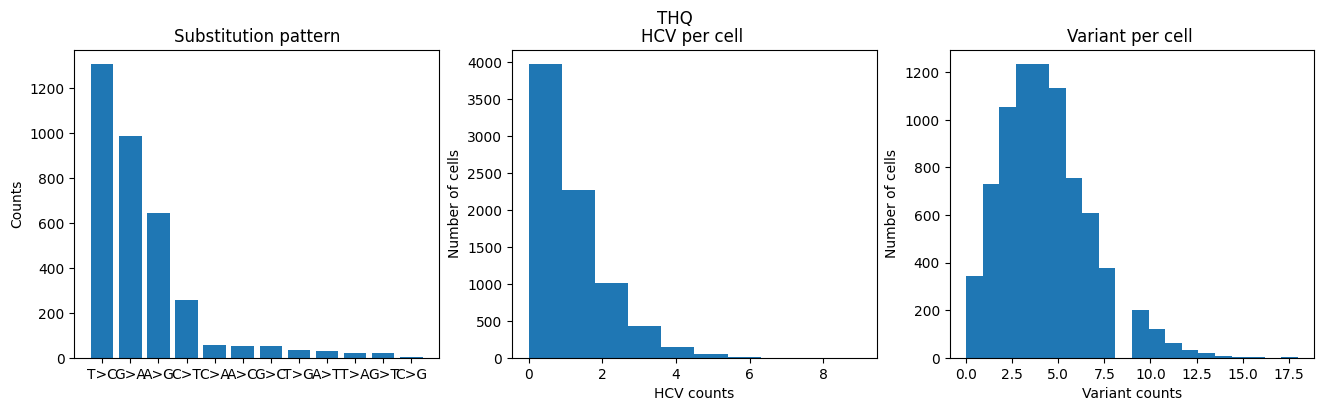

In [41]:
sample_name = "THQ"
main_dir = "/data3/wangxin/PBMC/" + sample_name + "/"
snv_dir = main_dir + "SNV/"
counts_dir = main_dir + "counts/"
bulk_snv = main_dir + sample_name + "_all.snv"
depth_file = main_dir + sample_name + "_mean_depth.csv"
snv_ls = os.listdir(snv_dir)
output_dir=main_dir + "outs/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

#germline variants cutoff setup
germline_vaf_co = 0.05
germline_cell_co = 0.9


#identify high confidence variants in each cell and make a dictionary for storage.
hc_var_dict = {}
for i in snv_ls:
    snv_file = open(snv_dir+i,"r")
    hc_var = []
    for j in snv_file.readlines():
        if "Chrom" not in j:
            line = j.strip().split("\t")
            depth = int(line[4]) + int(line[5])
            var_counts = int(line[5])
            strand_balance = int(line[16]) / var_counts
            vaf = var_counts / depth
            if depth >= 20 and var_counts >= 4 and strand_balance >= 0.3 and strand_balance <= 0.7 and vaf >= 0.05:
                hc_var.append((line[1] + line[2] + ">" + line[-1]))
    hc_var_dict[i[:-4]] = hc_var
                
#Count unique variants that are idetified.
all_var=[]
for i in hc_var_dict:
    all_var = all_var + hc_var_dict[i]

hc_var_stat = pd.Series(all_var).value_counts() 
print("Found %d high-confidence variants" %(len(hc_var_stat)))

#remove variants that fall in blacklist or poor alignment region.
bulk_var_pd = pd.read_table(bulk_snv)
germline_var_pd = bulk_var_pd.loc[pd.Series([float(i[:-1])/100 for i in bulk_var_pd["VarFreq"]])>0.9]
germline_var = [str(germline_var_pd.loc[i, "Position"])+germline_var_pd.loc[i, "Ref"]+">"+germline_var_pd.loc[i, "VarAllele"] for i in germline_var_pd.index]
germline_pos = germline_var_pd["Position"]

#add germline mutations from bulk to the list
germline_pool = germline_pool + germline_var

#poor alignment region
poor_alignment_region = list(range(302,316)) + list(range(513,526)) + list(range(3105,3110))
excluding_pos = list(germline_pos) + poor_alignment_region

#remove germline (from bulk) and poor alignment 
good_var = [i for i in hc_var_stat.index if int(i[:-3]) not in excluding_pos]
fil_hc_var_stat = hc_var_stat[good_var]
print("Removed %d/%d variants that are germline or located in poor alignment region, %d variants passed" %(len(hc_var_stat)-len(good_var), len(hc_var_stat), len(good_var)))

print("Write stats of HCVs...")
fil_hc_var_stat.to_csv(output_dir+sample_name + "_HCV_stat.csv")
fout = open(output_dir+sample_name+"_hcmut_perCell.tsv", 'w')
fout.write("Barcode\thcmut\n")
for i in hc_var_dict:
    fil_hcv = [j for j in hc_var_dict[i] if j in good_var]
    fout.write(i+"\t"+",".join(fil_hcv)+'\n')
fout.close()

#create a vaf matrix and fill in VAF

barcode = [i[:-4] for i in snv_ls]
hcc_cutoff = 1
count = 0
candidate_var = fil_hc_var_stat[fil_hc_var_stat >= hcc_cutoff]
candidate_pos = pd.Series([int(i[:-3]) for i in candidate_var.index], index = list(candidate_var.index)).sort_values()
vaf_df = pd.DataFrame(0, index = candidate_pos.index,  columns = barcode)
for i in barcode:
    count += 1
    count_df = pd.read_table(counts_dir+i+".counts", header=None)
    count_df.columns = ["Chrom", "Pos", "Ref", "Depth", "Ref", "Alt", "v1", "Ref_count", "Alt_count", "v2"]
    count_df.index = count_df["Pos"]
    
    for j in candidate_pos.index:
        pos = int(j[:-3])
        ref = j[-3]
        alt = j[-1]
        try:
            if count_df.loc[pos, "Alt"] == alt:
                vaf_df.loc[j, i] = count_df.loc[pos, "Alt_count"]/count_df.loc[pos, "Depth"]
        except:
            #print(j, i)
            next
    #print(count)


#print("Write a raw VAF table.")
#vaf_df.to_csv(output_dir + sample_name + "_raw_VAF.csv")

#remove cells with low depth (<10x)
depth_df = pd.read_csv(depth_file, header=None)
deep_cell = depth_df.loc[depth_df[1]>=10][0]
deep_vaf_df = vaf_df[deep_cell]
print("Removed %d cells with low coverage (<10x), %d cells remained." %(len(vaf_df.columns) - len(deep_vaf_df.columns), len(deep_vaf_df.columns)))

#remove germline variants according to vaf table of each cell.
somatic_ser = pd.Series([sum(deep_vaf_df.loc[i] >= germline_vaf_co) for i in deep_vaf_df.index], index = deep_vaf_df.index) < len(deep_vaf_df.columns) * germline_cell_co
final_vaf_df = deep_vaf_df.loc[somatic_ser]

new_germline = [i for i in deep_vaf_df.index if i not in final_vaf_df.index]
germline_pool = germline_pool + new_germline
print("Identified %d germline mutations from bulk and %d new germline mutations from the vaf matrix." %(len(germline_var), len(new_germline)))


#set vaf<0.05 as 0
final_vaf_df[final_vaf_df<0.05] = 0
print("Write the final VAF table.")
final_vaf_df.to_csv(output_dir + sample_name + "_mtSNV_final.csv")

#sort the df by occurence in population.
sorted_var_by_occur = pd.Series([sum(final_vaf_df.loc[i]>=0.05) for i in final_vaf_df.index], index = final_vaf_df.index).sort_values(ascending=False)
final_sorted_vaf = final_vaf_df.loc[sorted_var_by_occur.index]
print("Write final sorted VAF table")
final_sorted_vaf.to_csv(output_dir + sample_name + "_mtSNV_final_sorted.csv")

###plot
substitution_ser = pd.Series([i[-3:] for i in final_vaf_df.index], index = final_vaf_df.index).value_counts()
hcv_percell = pd.Series([len([j for j in hc_var_dict[i] if int(j[:-3]) not in excluding_pos]) for i in deep_cell])
var_per_cell_pd = pd.Series([sum(final_vaf_df[i]>=0.05) for i in final_vaf_df.columns], index=final_vaf_df.columns)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))
#plt.rcParams['figure.figsize'] = [5, 5]
fig.suptitle(sample_name)
ax1.bar(x= substitution_ser.index, height = substitution_ser)
ax1.set(title="Substitution pattern", xlabel="", ylabel="Counts", )

ax2.hist(hcv_percell, bins = len(hcv_percell.value_counts()))
ax2.set(title = "HCV per cell ", xlabel = "HCV counts", ylabel = "Number of cells")

ax3.hist(var_per_cell_pd, bins=20)
ax3.set(title = "Variant per cell ", xlabel = "Variant counts", ylabel = "Number of cells")

print("Job finished: %s." %(sample_name))

# SS2 - Embryo

Found 4207 high-confidence variants
Removed 34/4207 variants that are germline or located in poor alignment region, 4173 variants passed
Write stats of HCVs...
Removed 1 cells with low coverage (<10x), 1183 cells remained.
Identified 34 germline mutations from bulk and 4 new germline mutations from the vaf matrix.
Write the final VAF table.


/tmp/ipykernel_86248/2252854407.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_vaf_df[final_vaf_df<0.01] = 0
/data/wangxin/software/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


Write final sorted VAF table
Job finished: embryo.


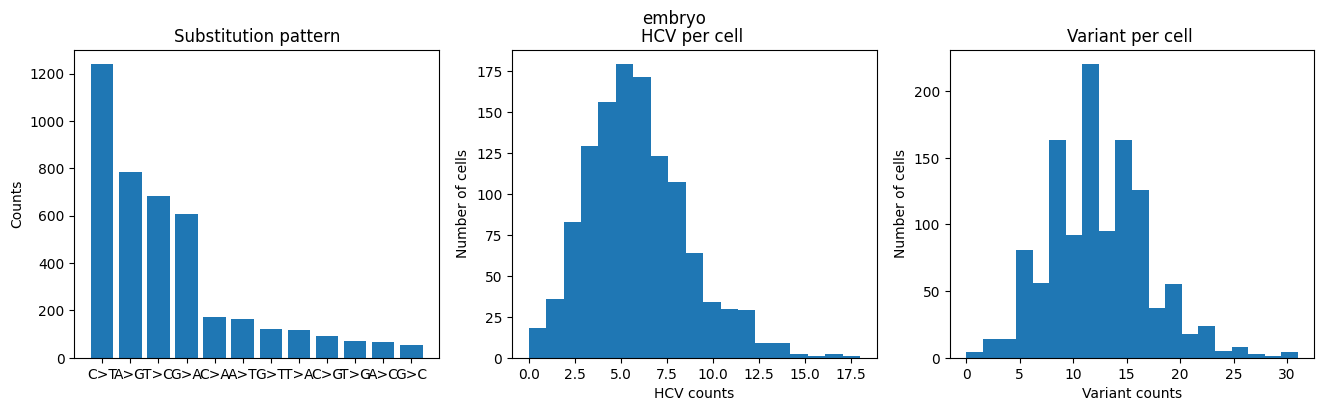

In [52]:
germline_pool=[]

sample_name = "embryo"
main_dir = "/data/wangxin/work/MT_bm/SS2/" + sample_name + "/tzj/"
snv_dir = main_dir + "SNV/"
counts_dir = main_dir + "counts/"
bulk_snv = main_dir + sample_name + "_all.snv"
depth_file = main_dir + sample_name + "_mean_depth.csv"
snv_ls = os.listdir(snv_dir)
output_dir=main_dir + "outs/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

#germline variants cutoff setup
germline_vaf_co = 0.05
germline_cell_co = 0.8


#identify high confidence variants in each cell and make a dictionary for storage.
hc_var_dict = {}
empty_barcode = []
for i in snv_ls:
    #snv_file.seek(0)
    snv_file = open(snv_dir+i,"r")
    contents = snv_file.readlines()
    if len(contents) == 1:
        #print(i)
        empty_barcode.append(i[:-4]) 
        #continue
    else:
        #print("bingo",i)
        hc_var = []
        for j in contents:
            #print(len(snv_file.readlines()))
            if "Chrom" not in j:
                #print(j)
                line = j.strip().split("\t")
                depth = int(line[4]) + int(line[5])
                var_counts = int(line[5])
                strand_balance = int(line[16]) / var_counts
                vaf = var_counts / depth
                #print(j)
                if depth >= 20 and var_counts >= 4 and strand_balance >= 0.3 and strand_balance <= 0.7 and vaf >= 0.05:
                    hc_var.append((line[1] + line[2] + ">" + line[-1]))
                    #print(i,j)
        hc_var_dict[i[:-4]] = hc_var
    #break
#Count unique variants that are idetified.
all_var=[]
for i in hc_var_dict:
    all_var = all_var + hc_var_dict[i]

hc_var_stat = pd.Series(all_var).value_counts() 
print("Found %d high-confidence variants" %(len(hc_var_stat)))

#remove variants that fall in blacklist or poor alignment region.
bulk_var_pd = pd.read_table(bulk_snv)
germline_var_pd = bulk_var_pd.loc[pd.Series([float(i[:-1])/100 for i in bulk_var_pd["VarFreq"]])>0.9]
germline_var = [str(germline_var_pd.loc[i, "Position"])+germline_var_pd.loc[i, "Ref"]+">"+germline_var_pd.loc[i, "VarAllele"] for i in germline_var_pd.index]
germline_pos = germline_var_pd["Position"]

#add germline mutations from bulk to the list
germline_pool = germline_pool + germline_var

#poor alignment region
poor_alignment_region = list(range(302,316)) + list(range(513,526)) + list(range(3105,3110))
excluding_pos = list(germline_pos) + poor_alignment_region

#remove germline (from bulk) and poor alignment 
good_var = [i for i in hc_var_stat.index if int(i[:-3]) not in excluding_pos]
fil_hc_var_stat = hc_var_stat[good_var]
print("Removed %d/%d variants that are germline or located in poor alignment region, %d variants passed" %(len(hc_var_stat)-len(good_var), len(hc_var_stat), len(good_var)))

print("Write stats of HCVs...")
fil_hc_var_stat.to_csv(output_dir+sample_name + "_HCV_stat.csv")
fout = open(output_dir+sample_name+"_hcmut_perCell.tsv", 'w')
fout.write("Barcode\thcmut\n")
for i in hc_var_dict:
    fil_hcv = [j for j in hc_var_dict[i] if j in good_var]
    fout.write(i+"\t"+",".join(fil_hcv)+'\n')
fout.close()

#create a vaf matrix and fill in VAF

barcode = [i[:-4] for i in snv_ls if i[:-4] not in empty_barcode]
hcc_cutoff = 1
count = 0
candidate_var = fil_hc_var_stat[fil_hc_var_stat >= hcc_cutoff]
candidate_pos = pd.Series([int(i[:-3]) for i in candidate_var.index], index = list(candidate_var.index)).sort_values()
vaf_df = pd.DataFrame(0, index = candidate_pos.index,  columns = barcode)
for i in barcode:
    count += 1
    count_df = pd.read_table(counts_dir+i+".counts", header=None)
    count_df.columns = ["Chrom", "Pos", "Ref", "Depth", "Ref", "Alt", "v1", "Ref_count", "Alt_count", "v2"]
    count_df.index = count_df["Pos"]
    
    for j in candidate_pos.index:
        pos = int(j[:-3])
        ref = j[-3]
        alt = j[-1]
        try:
            if count_df.loc[pos, "Alt"] == alt:
                vaf_df.loc[j, i] = count_df.loc[pos, "Alt_count"]/count_df.loc[pos, "Depth"]
        except:
            #print(j, i)
            next
    #print(count)


#print("Write a raw VAF table.")
#vaf_df.to_csv(output_dir + sample_name + "_raw_VAF.csv")

#remove cells with low depth (<10x)
depth_df = pd.read_csv(depth_file, header=None)
deep_cell = depth_df.loc[depth_df[1]>=10][0]
deep_vaf_df = vaf_df[deep_cell]
print("Removed %d cells with low coverage (<10x), %d cells remained." %(len(vaf_df.columns) - len(deep_vaf_df.columns), len(deep_vaf_df.columns)))

#remove germline variants according to vaf table of each cell.
somatic_ser = pd.Series([sum(deep_vaf_df.loc[i] >= germline_vaf_co) for i in deep_vaf_df.index], index = deep_vaf_df.index) < len(deep_vaf_df.columns) * germline_cell_co
final_vaf_df = deep_vaf_df.loc[somatic_ser]

new_germline = [i for i in deep_vaf_df.index if i not in final_vaf_df.index]
germline_pool = germline_pool + new_germline
print("Identified %d germline mutations from bulk and %d new germline mutations from the vaf matrix." %(len(germline_var), len(new_germline)))


#set vaf<0.05 as 0
final_vaf_df[final_vaf_df<0.01] = 0
print("Write the final VAF table.")
final_vaf_df.to_csv(output_dir + sample_name + "_mtSNV_final.csv")

#sort the df by occurence in population.
sorted_var_by_occur = pd.Series([sum(final_vaf_df.loc[i]>=0.05) for i in final_vaf_df.index], index = final_vaf_df.index).sort_values(ascending=False)
final_sorted_vaf = final_vaf_df.loc[sorted_var_by_occur.index]
print("Write final sorted VAF table")
final_sorted_vaf.to_csv(output_dir + sample_name + "_mtSNV_final_sorted.csv")

###plot
substitution_ser = pd.Series([i[-3:] for i in final_vaf_df.index], index = final_vaf_df.index).value_counts()
hcv_percell = pd.Series([len([j for j in hc_var_dict[i] if int(j[:-3]) not in excluding_pos]) for i in deep_cell])
var_per_cell_pd = pd.Series([sum(final_vaf_df[i]>=0.05) for i in final_vaf_df.columns], index=final_vaf_df.columns)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))
#plt.rcParams['figure.figsize'] = [5, 5]
fig.suptitle(sample_name)
ax1.bar(x= substitution_ser.index, height = substitution_ser)
ax1.set(title="Substitution pattern", xlabel="", ylabel="Counts", )

ax2.hist(hcv_percell, bins = len(hcv_percell.value_counts()))
ax2.set(title = "HCV per cell ", xlabel = "HCV counts", ylabel = "Number of cells")

ax3.hist(var_per_cell_pd, bins=20)
ax3.set(title = "Variant per cell ", xlabel = "Variant counts", ylabel = "Number of cells")

print("Job finished: %s." %(sample_name))

# SS2 - T cells (GSE193439)

In [6]:
germline_pool={}

Found 1139 high-confidence variants
Removed 1/1139 variants that are germline or located in poor alignment region, 1138 variants passed
Write stats of HCVs...
Calculating VAF of each variant and fill out the VAF matrix...
Removed 0 cells with low coverage (<10x), 380 cells remained.
Identified 0 germline mutations from bulk and 15 new germline mutations from the vaf matrix.
Write the final VAF table to /syn1/wangxin/work/SS2/Li/samples/MS0816/outs_vc1/MS0816_mtSNV_final.csv


/tmp/ipykernel_97067/72208601.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_vaf_df[final_vaf_df<0.01] = 0
/data/wangxin/software/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


Write final sorted VAF table to /syn1/wangxin/work/SS2/Li/samples/MS0816/outs_vc1/MS0816_mtSNV_final_sorted.csv
Job finished: MS0816.


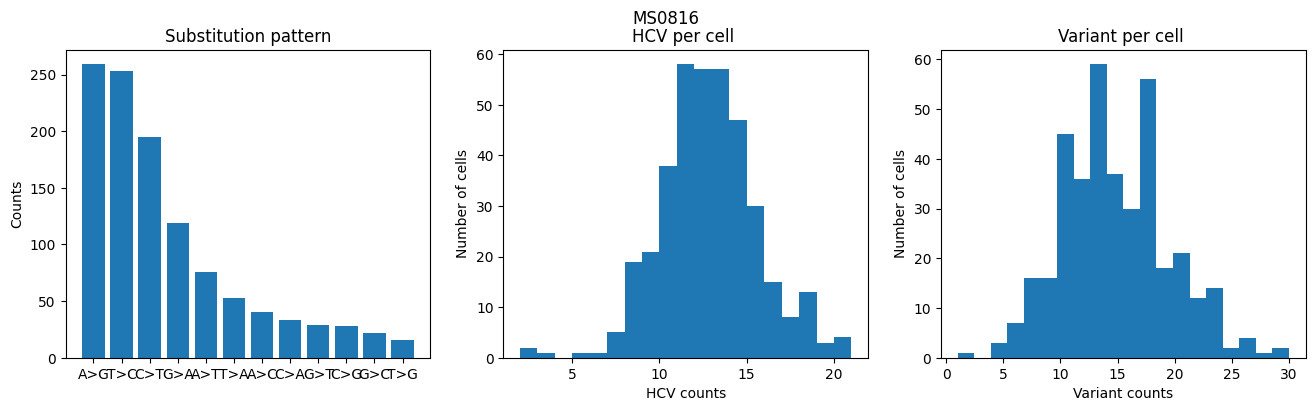

In [28]:

germline_ls = []
sample_name = "MS0816"
vc = 1 #variant counts cutoff
bulk_flag = 0
main_dir = "/syn1/wangxin/work/SS2/Li/samples/"+sample_name+"/"
snv_dir = main_dir + "snv/"
counts_dir = main_dir + "counts/"
#check if bulk SNV is used.
if bulk_flag == 1:
    bulk_snv = main_dir + "bulk/" + sample_name + ".snv"

depth_file = main_dir + sample_name + "_mean_depth.csv"
snv_ls = os.listdir(snv_dir)
output_dir=main_dir + "outs_vc" + str(vc) +"/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

#germline variants cutoff setup
germline_vaf_co = 0.01
germline_cell_co = 0.8


#identify high confidence variants in each cell and make a dictionary for storage.
hc_var_dict = {}
empty_barcode = []
for i in snv_ls:
    #snv_file.seek(0)
    snv_file = open(snv_dir+i,"r")
    contents = snv_file.readlines()
    if len(contents) == 1:
        #print(i)
        empty_barcode.append(i[:-4]) 
        #continue
    else:
        #print("bingo",i)
        hc_var = []
        for j in contents:
            #print(len(snv_file.readlines()))
            if "Chrom" not in j:
                #print(j)
                line = j.strip().split("\t")
                depth = int(line[4]) + int(line[5])
                var_counts = int(line[5])
                strand_balance = int(line[16]) / var_counts
                vaf = var_counts / depth
                #print(j)
                if line[-1] in ["A","G","C","T"]:
                    if depth >= 20 and var_counts >= 4 and strand_balance >= 0.3 and strand_balance <= 0.7 and vaf >= 0.05:
                        hc_var.append((line[1] + line[2] + ">" + line[-1]))
                        #print(i,j)
        hc_var_dict[i[:-4]] = hc_var
    #break
#Count unique variants that are idetified.
all_var=[]
for i in hc_var_dict:
    all_var = all_var + hc_var_dict[i]

hc_var_stat = pd.Series(all_var).value_counts() 
print("Found %d high-confidence variants" %(len(hc_var_stat)))

#poor alignment region
poor_alignment_region = list(range(302,316)) + list(range(513,526)) + list(range(3105,3111))

#remove variants that fall in gerline mutation called using (pseudo-)bulk data.
if bulk_flag == 1:
    bulk_var_pd = pd.read_table(bulk_snv)
    germline_var_pd = bulk_var_pd.loc[pd.Series([float(i[:-1])/100 for i in bulk_var_pd["VarFreq"]])>0.9]
    germline_var = [str(germline_var_pd.loc[i, "Position"])+germline_var_pd.loc[i, "Ref"]+">"+germline_var_pd.loc[i, "VarAllele"] for i in germline_var_pd.index]
    germline_pos = germline_var_pd["Position"]

    #add germline mutations from bulk to the list
    germline_ls = germline_ls + germline_var
elif bulk_flag == 0:
    germline_pos = ""

excluding_pos = list(germline_pos) + poor_alignment_region

#remove germline (from bulk) and poor alignment 
good_var = [i for i in hc_var_stat.index if int(i[:-3]) not in excluding_pos]
fil_hc_var_stat = hc_var_stat[good_var]
print("Removed %d/%d variants that are germline or located in poor alignment region, %d variants passed" %(len(hc_var_stat)-len(good_var), len(hc_var_stat), len(good_var)))

print("Write stats of HCVs...")
fil_hc_var_stat.to_csv(output_dir+sample_name + "_HCV_stat.csv")
fout = open(output_dir+sample_name+"_hcmut_perCell.tsv", 'w')
fout.write("Barcode\thcmut\n")
for i in hc_var_dict:
    fil_hcv = [j for j in hc_var_dict[i] if j in good_var]
    fout.write(i+"\t"+",".join(fil_hcv)+'\n')
fout.close()

print("Calculating VAF of each variant and fill out the VAF matrix...")
#create a vaf matrix and fill in VAF

barcode = [i[:-4] for i in snv_ls if i[:-4] not in empty_barcode]
hcc_cutoff = 1
count = 0
candidate_var = fil_hc_var_stat[fil_hc_var_stat >= hcc_cutoff]
candidate_pos = pd.Series([int(i[:-3]) for i in candidate_var.index], index = list(candidate_var.index)).sort_values()
vaf_df = pd.DataFrame(0, index = candidate_pos.index,  columns = barcode)
for i in barcode:
    count += 1
    count_df = pd.read_table(counts_dir+i+".counts", header=None)
    count_df.columns = ["Chrom", "Pos", "Ref", "Depth", "Ref", "Alt", "v1", "Ref_count", "Alt_count", "v2"]
    count_df.index = count_df["Pos"]
    
    for j in candidate_pos.index:
        pos = int(j[:-3])
        ref = j[-3]
        alt = j[-1]
        try:
            if count_df.loc[pos, "Alt"] == alt and count_df.loc[pos, "Alt_count"] >= vc:
                vaf_df.loc[j, i] = count_df.loc[pos, "Alt_count"]/count_df.loc[pos, "Depth"]
        except:
            #print(j, i)
            next
    #print(count)


#print("Write a raw VAF table.")
#vaf_df.to_csv(output_dir + sample_name + "_raw_VAF.csv")

#remove cells with low depth (<10x)
depth_df = pd.read_csv(depth_file, header=None)
deep_cell = depth_df.loc[depth_df[1]>=10][0]
deep_vaf_df = vaf_df[deep_cell]
print("Removed %d cells with low coverage (<10x), %d cells remained." %(len(vaf_df.columns) - len(deep_vaf_df.columns), len(deep_vaf_df.columns)))

#remove germline variants according to vaf table of each cell.
somatic_ser = pd.Series([sum(deep_vaf_df.loc[i] >= germline_vaf_co) for i in deep_vaf_df.index], index = deep_vaf_df.index) < len(deep_vaf_df.columns) * germline_cell_co
final_vaf_df = deep_vaf_df.loc[somatic_ser]

new_germline = [i for i in deep_vaf_df.index if i not in final_vaf_df.index]
germline_ls = germline_ls + new_germline
germline_pool[sample_name] = germline_ls
print("Identified %d germline mutations from bulk and %d new germline mutations from the vaf matrix." %(len(germline_pos), len(new_germline)))


#set vaf<0.01 as 0
final_vaf_df[final_vaf_df<0.01] = 0
final_vaf_path = f"{output_dir}{sample_name}_mtSNV_final.csv"
print(f"Write the final VAF table to {final_vaf_path}")
final_vaf_df.to_csv(final_vaf_path)

#sort the df by occurence in population.
sorted_var_by_occur = pd.Series([sum(final_vaf_df.loc[i]>=germline_vaf_co) for i in final_vaf_df.index], index = final_vaf_df.index).sort_values(ascending=False)
final_sorted_vaf = final_vaf_df.loc[sorted_var_by_occur.index]
final_sorted_vaf_path = f"{output_dir}{sample_name}_mtSNV_final_sorted.csv"
print(f"Write final sorted VAF table to {final_sorted_vaf_path}")
final_sorted_vaf.to_csv(final_sorted_vaf_path)

###plot
substitution_ser = pd.Series([i[-3:] for i in final_vaf_df.index], index = final_vaf_df.index).value_counts()
hcv_percell = pd.Series([len([j for j in hc_var_dict[i] if int(j[:-3]) not in excluding_pos]) for i in deep_cell])
var_per_cell_pd = pd.Series([sum(final_vaf_df[i]>=germline_vaf_co) for i in final_vaf_df.columns], index=final_vaf_df.columns)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))
#plt.rcParams['figure.figsize'] = [5, 5]
fig.suptitle(sample_name)
ax1.bar(x= substitution_ser.index, height = substitution_ser)
ax1.set(title="Substitution pattern", xlabel="", ylabel="Counts", )

ax2.hist(hcv_percell, bins = len(hcv_percell.value_counts()))
ax2.set(title = "HCV per cell ", xlabel = "HCV counts", ylabel = "Number of cells")

ax3.hist(var_per_cell_pd, bins=20)
ax3.set(title = "Variant per cell ", xlabel = "Variant counts", ylabel = "Number of cells")

print("Job finished: %s." %(sample_name))

Found 981 high-confidence variants
Removed 3/981 variants that are germline or located in poor alignment region, 978 variants passed
Write stats of HCVs...
Calculating VAF of each variant and fill out the VAF matrix...
Removed 0 cells with low coverage (<10x), 271 cells remained.
Identified 0 germline mutations from bulk and 10 new germline mutations from the vaf matrix.
Write the final VAF table to /syn1/wangxin/work/SS2/Li/samples/SLE232/outs_vc1/SLE232_mtSNV_final.csv


/tmp/ipykernel_97067/3578129519.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_vaf_df[final_vaf_df<0.01] = 0
/data/wangxin/software/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3713: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


Write final sorted VAF table to /syn1/wangxin/work/SS2/Li/samples/SLE232/outs_vc1/SLE232_mtSNV_final_sorted.csv
Job finished: SLE232.


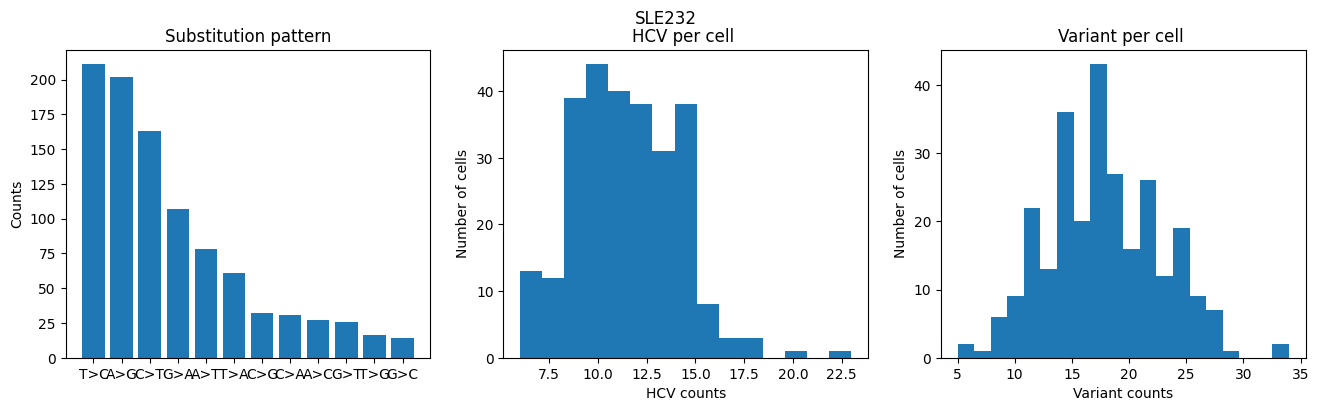

In [35]:

germline_ls = []
sample_name = "SLE232"
vc = 1 #variant counts cutoff
bulk_flag = 0
main_dir = "/syn1/wangxin/work/SS2/Li/samples/"+sample_name+"/"
snv_dir = main_dir + "snv/"
counts_dir = main_dir + "counts/"
#check if bulk SNV is used.
if bulk_flag == 1:
    bulk_snv = main_dir + "bulk/" + sample_name + ".snv"

depth_file = main_dir + sample_name + "_mean_depth.csv"
snv_ls = os.listdir(snv_dir)
output_dir=main_dir + "outs_vc" + str(vc) +"/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

#germline variants cutoff setup
germline_vaf_co = 0.01
germline_cell_co = 0.8


#identify high confidence variants in each cell and make a dictionary for storage.
hc_var_dict = {}
empty_barcode = []
for i in snv_ls:
    #snv_file.seek(0)
    snv_file = open(snv_dir+i,"r")
    contents = snv_file.readlines()
    if len(contents) == 1:
        #print(i)
        empty_barcode.append(i[:-4]) 
        #continue
    else:
        #print("bingo",i)
        hc_var = []
        for j in contents:
            #print(len(snv_file.readlines()))
            if "Chrom" not in j:
                #print(j)
                line = j.strip().split("\t")
                depth = int(line[4]) + int(line[5])
                var_counts = int(line[5])
                strand_balance = int(line[16]) / var_counts
                vaf = var_counts / depth
                #print(j)
                if line[-1] in ["A","G","C","T"]:
                    if depth >= 20 and var_counts >= 4 and strand_balance >= 0.3 and strand_balance <= 0.7 and vaf >= 0.05:
                        hc_var.append((line[1] + line[2] + ">" + line[-1]))
                        #print(i,j)
        hc_var_dict[i[:-4]] = hc_var
    #break
#Count unique variants that are idetified.
all_var=[]
for i in hc_var_dict:
    all_var = all_var + hc_var_dict[i]

hc_var_stat = pd.Series(all_var).value_counts() 
print("Found %d high-confidence variants" %(len(hc_var_stat)))

#poor alignment region
poor_alignment_region = list(range(302,316)) + list(range(513,526)) + list(range(3105,3111))

#remove variants that fall in gerline mutation called using (pseudo-)bulk data.
if bulk_flag == 1:
    bulk_var_pd = pd.read_table(bulk_snv)
    germline_var_pd = bulk_var_pd.loc[pd.Series([float(i[:-1])/100 for i in bulk_var_pd["VarFreq"]])>0.9]
    germline_var = [str(germline_var_pd.loc[i, "Position"])+germline_var_pd.loc[i, "Ref"]+">"+germline_var_pd.loc[i, "VarAllele"] for i in germline_var_pd.index]
    germline_pos = germline_var_pd["Position"]

    #add germline mutations from bulk to the list
    germline_ls = germline_ls + germline_var
elif bulk_flag == 0:
    germline_pos = ""

excluding_pos = list(germline_pos) + poor_alignment_region

#remove germline (from bulk) and poor alignment 
good_var = [i for i in hc_var_stat.index if int(i[:-3]) not in excluding_pos]
fil_hc_var_stat = hc_var_stat[good_var]
print("Removed %d/%d variants that are germline or located in poor alignment region, %d variants passed" %(len(hc_var_stat)-len(good_var), len(hc_var_stat), len(good_var)))

print("Write stats of HCVs...")
fil_hc_var_stat.to_csv(output_dir+sample_name + "_HCV_stat.csv")
fout = open(output_dir+sample_name+"_hcmut_perCell.tsv", 'w')
fout.write("Barcode\thcmut\n")
for i in hc_var_dict:
    fil_hcv = [j for j in hc_var_dict[i] if j in good_var]
    fout.write(i+"\t"+",".join(fil_hcv)+'\n')
fout.close()

print("Calculating VAF of each variant and fill out the VAF matrix...")
#create a vaf matrix and fill in VAF

barcode = [i[:-4] for i in snv_ls if i[:-4] not in empty_barcode]
hcc_cutoff = 1
count = 0
candidate_var = fil_hc_var_stat[fil_hc_var_stat >= hcc_cutoff]
candidate_pos = pd.Series([int(i[:-3]) for i in candidate_var.index], index = list(candidate_var.index)).sort_values()
vaf_df = pd.DataFrame(0, index = candidate_pos.index,  columns = barcode)
for i in barcode:
    count += 1
    count_df = pd.read_table(counts_dir+i+".counts", header=None)
    count_df.columns = ["Chrom", "Pos", "Ref", "Depth", "Ref", "Alt", "v1", "Ref_count", "Alt_count", "v2"]
    count_df.index = count_df["Pos"]
    
    for j in candidate_pos.index:
        pos = int(j[:-3])
        ref = j[-3]
        alt = j[-1]
        try:
            if count_df.loc[pos, "Alt"] == alt and count_df.loc[pos, "Alt_count"] >= vc:
                vaf_df.loc[j, i] = count_df.loc[pos, "Alt_count"]/count_df.loc[pos, "Depth"]
        except:
            #print(j, i)
            next
    #print(count)


#print("Write a raw VAF table.")
#vaf_df.to_csv(output_dir + sample_name + "_raw_VAF.csv")

#remove cells with low depth (<10x)
depth_df = pd.read_csv(depth_file, header=None)
deep_cell = depth_df.loc[depth_df[1]>=10][0]
deep_vaf_df = vaf_df[deep_cell]
print("Removed %d cells with low coverage (<10x), %d cells remained." %(len(vaf_df.columns) - len(deep_vaf_df.columns), len(deep_vaf_df.columns)))

#remove germline variants according to vaf table of each cell.
somatic_ser = pd.Series([sum(deep_vaf_df.loc[i] >= germline_vaf_co) for i in deep_vaf_df.index], index = deep_vaf_df.index) < len(deep_vaf_df.columns) * germline_cell_co
final_vaf_df = deep_vaf_df.loc[somatic_ser]

new_germline = [i for i in deep_vaf_df.index if i not in final_vaf_df.index]
germline_ls = germline_ls + new_germline
germline_pool[sample_name] = germline_ls
print("Identified %d germline mutations from bulk and %d new germline mutations from the vaf matrix." %(len(germline_pos), len(new_germline)))


#set vaf<0.01 as 0
final_vaf_df[final_vaf_df<0.01] = 0
final_vaf_path = f"{output_dir}{sample_name}_mtSNV_final.csv"
print(f"Write the final VAF table to {final_vaf_path}")
final_vaf_df.to_csv(final_vaf_path)

#sort the df by occurence in population.
sorted_var_by_occur = pd.Series([sum(final_vaf_df.loc[i]>=germline_vaf_co) for i in final_vaf_df.index], index = final_vaf_df.index).sort_values(ascending=False)
final_sorted_vaf = final_vaf_df.loc[sorted_var_by_occur.index]
final_sorted_vaf_path = f"{output_dir}{sample_name}_mtSNV_final_sorted.csv"
print(f"Write final sorted VAF table to {final_sorted_vaf_path}")
final_sorted_vaf.to_csv(final_sorted_vaf_path)

###plot
substitution_ser = pd.Series([i[-3:] for i in final_vaf_df.index], index = final_vaf_df.index).value_counts()
hcv_percell = pd.Series([len([j for j in hc_var_dict[i] if int(j[:-3]) not in excluding_pos]) for i in deep_cell])
var_per_cell_pd = pd.Series([sum(final_vaf_df[i]>=germline_vaf_co) for i in final_vaf_df.columns], index=final_vaf_df.columns)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))
#plt.rcParams['figure.figsize'] = [5, 5]
fig.suptitle(sample_name)
ax1.bar(x= substitution_ser.index, height = substitution_ser)
ax1.set(title="Substitution pattern", xlabel="", ylabel="Counts", )

ax2.hist(hcv_percell, bins = len(hcv_percell.value_counts()))
ax2.set(title = "HCV per cell ", xlabel = "HCV counts", ylabel = "Number of cells")

ax3.hist(var_per_cell_pd, bins=20)
ax3.set(title = "Variant per cell ", xlabel = "Variant counts", ylabel = "Number of cells")

print("Job finished: %s." %(sample_name))